# Regression models

## Simple linear regression example

The simplest linear regression model has a slope and intercept coefficient and normally distributed noise. We can write it as follows:

$$y = X \beta + \epsilon$$

for some vector of outcomes $y$ (of length $n$), matrix of covariates $X$ ($n \times p$), and vectors of unknown coefficients and residuals.

This model is not probabilistic. To express this as a probabilistic model, we make an **assumption** about the distribution of the residuals and the parameters, such as this: $\epsilon \sim Normal(0, \sigma)$.

We can then re-write the linear regression model as follows:

$$
y_n \sim \textrm{Normal}(\alpha + \beta X_n, \sigma)
$$

In this new parametrization, the intercept and slope parameters are $\alpha$ and $\beta$, and they are normally distributed with scale $\sigma$.

In [23]:
%run shortcut_imports.ipy

/Users/schofield/anaconda/envs/bayesml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [72]:
%%writefile regr_simple.stan
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;    
}
model {
    y ~ normal(alpha + beta * x, sigma);
}

Overwriting regr_simple.stan


In [73]:
from sklearn.datasets import load_diabetes

In [74]:
diabetes = load_diabetes()

In [75]:
diabetes.keys()

dict_keys(['data', 'target'])

In [76]:
X = diabetes.data
y = diabetes.target

In [77]:
X.shape

(442, 10)

In [78]:
y.shape

(442,)

In [79]:
import pystan
sm = pystan.StanModel(file='regr_simple.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ffc4eddcf5ee82a011fdf8bbce3479bc NOW.


In [80]:
data = {'N': len(X),
        'x': X[:, 0],
        'y': y}

In [81]:
fit = sm.sampling(data=data, iter=10000, chains=4)

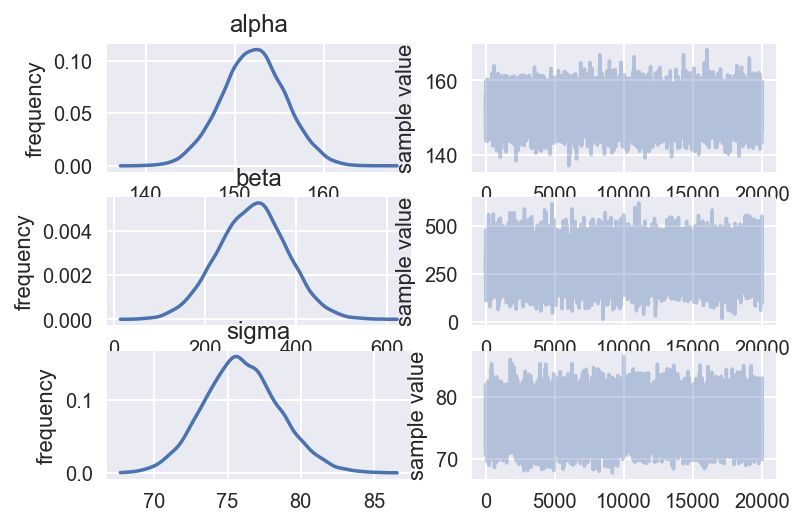

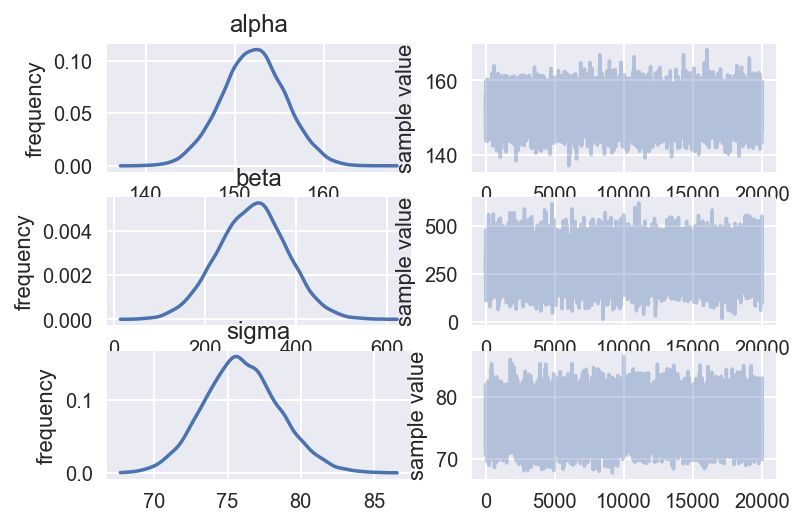

In [82]:
fit.traceplot()

In [83]:
fit.model_pars

['alpha', 'beta', 'sigma']

In [84]:
params = fit.extract()

In [85]:
params.keys()

odict_keys(['alpha', 'beta', 'sigma', 'lp__'])

In [87]:
params['alpha']

array([ 155.65331336,  152.55945511,  146.25795139, ...,  156.61679429,
        149.5358086 ,  153.44573327])

In [86]:
len(params['alpha'])

20000

In [88]:
params['alpha'][-1]

153.4457332716147

In [104]:
means = fit.get_posterior_mean()
means.shape

(4, 4)

Size $(m, n)$:
- $m$ parameters (= len(params.keys()))
- $n$ chains (number of times sm.sampling was called)

In [90]:
means[0]

array([ 152.11044776,  152.07004682,  152.15444896,  152.12721839])

In [91]:
param_means = {param: means[i, -1] for (i, param) in enumerate(params)}

In [92]:
param_means

{'alpha': 152.12721838711528,
 'beta': 303.05857858720293,
 'lp__': -2130.2083806706132,
 'sigma': 75.940627646941152}

In [93]:
x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

In [94]:
map_y = param_means['alpha'] + param_means['beta'] * x

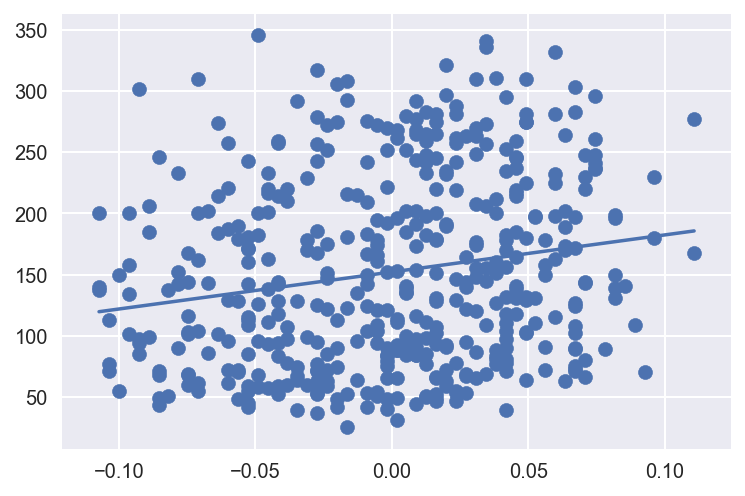

In [95]:
plt.plot(x, map_y)
plt.scatter(X[:, 0], y)

In [163]:
X.shape

(442, 10)

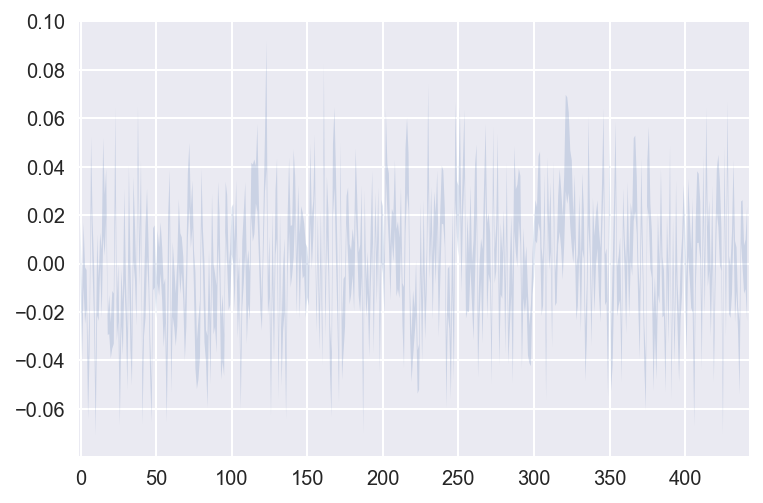

In [162]:
sns.tsplot(X.T, interpolate=False, marker='')

### Exercise

Superimpose the posterior distribution (e.g. via colour shading) over the data points in the first feature dimension (0).



In [96]:
# Look up: sns.tsplot(..., err_style="boot_traces", n_boot=500)

In [97]:
sns.tsplot?

### Richer linear regression examples

In [98]:
%%writefile regr_matrix.stan
data {
    int<lower=0> N;   // number of data points
    int<lower=0> K;   // number of predictors
    matrix[N, K] x;   // predictor matrix
    vector[N] y;      // targets
}
parameters {
    real alpha;       // intercept
    vector[K] beta;   // coefficients of predictors
    real<lower=0> sigma;    // error scale
}
model {
    y ~ normal(x * beta + alpha, sigma);   // likelihood
}

Overwriting regr_matrix.stan


### Question: What happens if you use the original order in the model spec: "alpha + beta * x"?

In [99]:
data2 = data.copy()

In [100]:
data2['x'] = X
data2['K'] = X.shape[1]

In [102]:
sm2 = pystan.StanModel(file='regr_matrix.stan')
fit2 = sm2.sampling(data=data2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_61b2773a60571da5de27463c7f4e1f95 NOW.


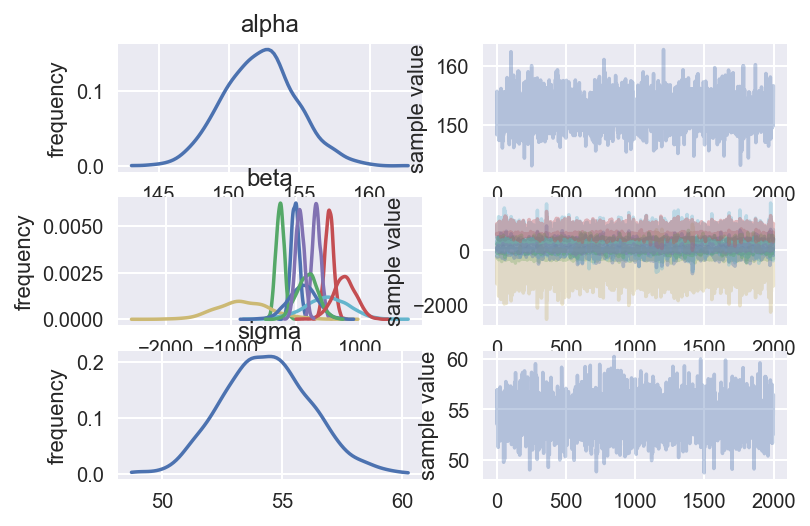

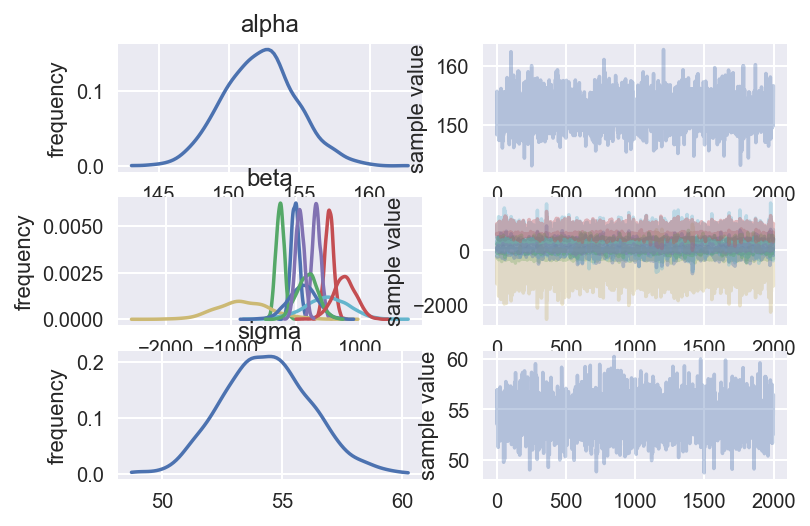

In [103]:
fit2.traceplot()

### Robust noise models

Normally linear regression is performed by modelling the noise $\epsilon$ as a normal distribution. You can perform more "robust" regression by modelling the noise term differently -- for example, as a Student t distribution.

### Exercise: try modifying the above as follows:

```
data {
    ...
    real<lower=0> nu;
}
...
model {
    y ~ student_t(nu, alpha + beta * x, sigma);
}
```

In [ ]:
plt.plot()

# Time-series models

In [109]:
asx = pd.HDFStore('/data/ASX2.h5')

In [120]:
len(asx.keys())

43

In [111]:
asx.keys()[:5]

['/ALL', '/AMC', '/AMP', '/ANZ', '/APA']

In [127]:
anz_close_changes = asx['/ANZ']['Adjusted Close'].pct_change().dropna()

In [128]:
anz_close_changes[:5]

Date
1988-02-29    0.059307
1988-03-31    0.120013
1988-04-29    0.071427
1988-05-31    0.095422
1988-06-30   -0.081640
Name: Adjusted Close, dtype: float64

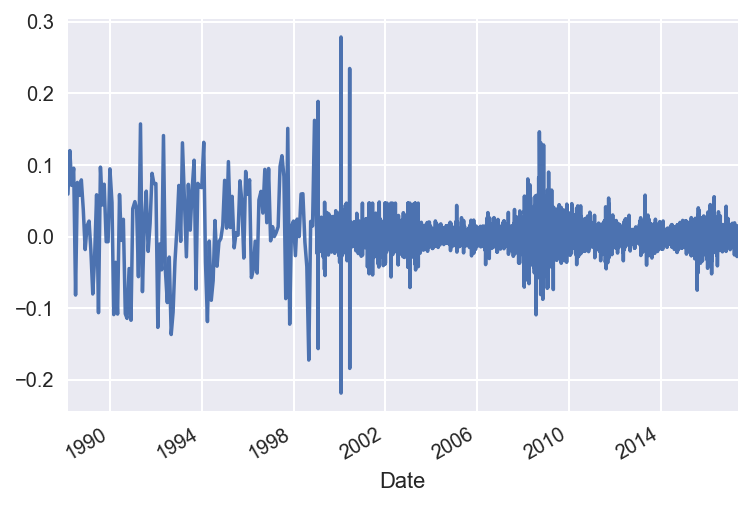

In [129]:
anz_close_changes.plot()

Volatility appears to have been consistently lower since January 2000.

In [146]:
anz_close_changes.idxmax(), anz_close_changes.idxmin()

(Timestamp('2000-01-26 00:00:00'), Timestamp('2000-01-27 00:00:00'))

## Autoregressive models

A first-order autoregressive (AR(1)) model assumes that each data value $y_n$ is related to the previous data value $y_{n-1}$ as follows:

$$
y_n \sim \textrm{Normal}(\alpha + \beta y_{n-1}, \sigma)
$$

This can be coded up in Stan as follows:

In [133]:
%%writefile ar1.stan
data {
      int<lower=0> N;
      vector[N] y;
    }
    parameters {
      real alpha;
      real beta;
      real<lower=0> sigma;
} model {
      for (n in 2:N)
        y[n] ~ normal(alpha + beta * y[n-1], sigma);
}

Writing ar1.stan


In [134]:
sm = pystan.StanModel(file='ar1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b551cd022f873857d94639f70be15194 NOW.


In [150]:
data = {'y': anz_close.values,
        'N': len(anz_close)}

In [153]:
fit = sm.sampling(data, iter=10000)

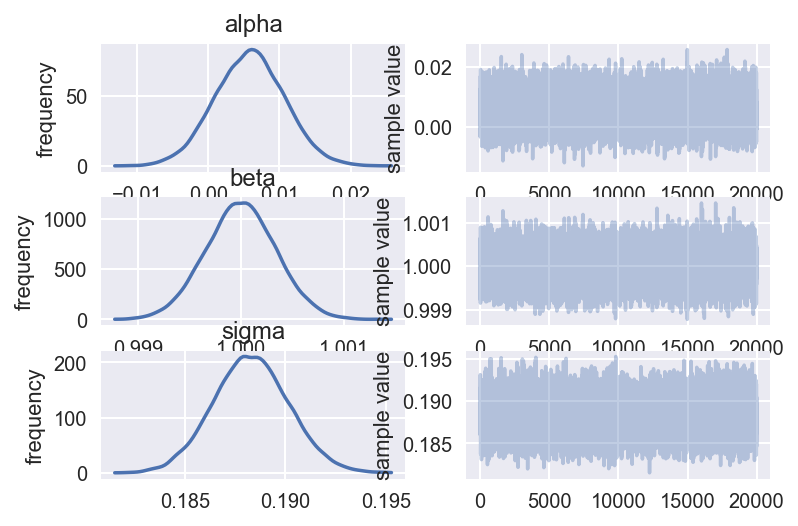

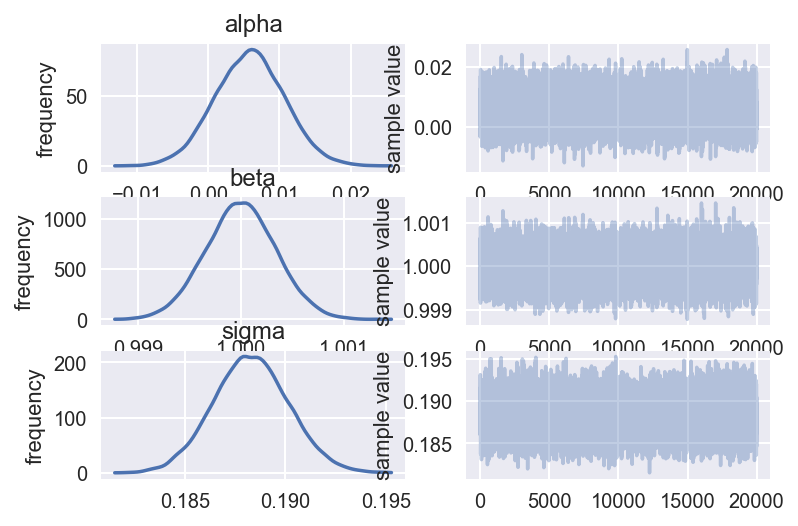

In [154]:
fit.traceplot()

### Question: is the data stationary?

i.e. what is $\beta$? Is it 1?

### Assumptions versus testing the data

In general, it is a better idea to discover whether the data has certain properties while fitting a model rather than **assuming** this to be true. This is straightforward using Bayesian methods and flexible modelling tools like PyStan and PyMC3.

### Exercise: are the day-on-day % changes in the data stationary?

### Hidden Markov models (HMM)

Hidden Markov models a discrete mixture models where the mixture components form a latent Markov chain.

Hidden Markov models are used to model time-series data in applications such as temporal pattern recognition, including:
- acoustic models for speech recognition
- facial expression identification in videos
- person recognition from gait
- handwriting recognition
- gesture recognition
- part-of-speech tagging
- bioinformatics

#### Description from Wikipedia

<blockquote>
A hidden Markov model can be considered a generalization of a mixture model where the hidden variables (or latent variables), which control the mixture component to be selected for each observation, are related through a Markov process rather than independent of each other.
</blockquote>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/HiddenMarkovModel.svg/600px-HiddenMarkovModel.svg.png"/>

Probabilistic parameters of a hidden Markov model (example):
- $X$ — states
- $y$ — possible observations
- $a$ — state transition probabilities
- $b$ — output probabilities

<img src="https://upload.wikimedia.org/wikipedia/commons/1/13/HMMsequence.svg">

#### Explanation
One goal in fitting an HMM is to determine which sequence of states ${1,...,5}$ was most likely to have generated the observed output sequence (below the dashed line).

Most attempts to model patterns as HMMs take a non-Bayesian approach (maximum likelihood estimation). This is known to be less accurate and stable than a full Bayesian treatment [Sipos 2016].

Until recently the programming complexity and computational burden of Bayesian HMM models have been too great, but now this is within reach with the latest generation of tools like PyStan, PyMC3 and Edward:

## References

- [Sipos 2016]: Sipos, I. Róbert. Parallel stratified MCMC sampling of AR-HMMs for stochastic time series prediction. In: Proceedings, 4th Stochastic Modeling Techniques and Data Analysis International Conference with Demographics Workshop (SMTDA2016), pp. 295-306. Valletta, 2016.